In [22]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
import libpysal
from sklearn.model_selection import train_test_split, GridSearchCV
import os
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter

In [23]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [24]:
rng = np.random.default_rng()

In [44]:
def load_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        print(filename)
        df1 = pd.read_csv(path + filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
        
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
#     df.plot(figsize = (40,40), column = "y")
#     plt.show()
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df 

In [45]:
# df15 = load_data(2015)
# df16 = load_data(2016)
df17 = load_data(2017)
df18 = load_data(2018)
df19 = load_data(2019)

eindhoven17.csv_filled_.csv
eindhoven18.csv_filled_.csv
eindhoven19.csv_filled_.csv


In [46]:
df19.shape

(6174, 44)

In [27]:
X_train = df17[df17.columns[:-5]]
X_val = df18[df18.columns[:-5]]
X_test = df19[df19.columns[:-5]]

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [35]:
c = 2
cluster_model = KMeans(n_clusters = c, random_state = 1)
train_l = pd.DataFrame(cluster_model.fit_predict(X_train))
val_l = pd.DataFrame(cluster_model.predict(X_val))
test_l = pd.DataFrame(cluster_model.predict(X_test))

In [36]:
X_train = df17[df17.columns[:-5]]
Y_train = df17.y
Y1_train = df17["y-1"]

X_val = df18[df18.columns[:-5]]
Y_val = df18.y
Y1_val = df18["y-1"]
# weights
wt = libpysal.weights.DistanceBand.from_dataframe(df17, threshold=150, binary = True, silence_warnings = True)
wv = libpysal.weights.DistanceBand.from_dataframe(df18, threshold=150, binary = True, silence_warnings = True)

In [37]:
X_test = df19[df19.columns[:-5]]
Y_test = df19.y
Y1_test = df19["y-1"]
# weights
wtest = libpysal.weights.DistanceBand.from_dataframe(df19, threshold=150, binary = True, silence_warnings = True)

In [38]:
Counter(test_l[0])

Counter({0: 1859, 1: 4315})

In [39]:
neighbors = [wv.neighbors[x] for x in wv.neighbors]  # ONly calculate Yt-1 val because at training it is just fitting the model
Y1_val = np.array([Y1_val[x].sum() for x in neighbors])
Y1_val[np.where(Y1_val == 0)[0]] = 0.5

neighbors = [wtest.neighbors[x] for x in wtest.neighbors]  # ONly calculate Yt-1 val because at training it is just fitting the model
Y1_test = np.array([Y1_test[x].sum() for x in neighbors])
Y1_test[np.where(Y1_test == 0)[0]] = 0.5

In [40]:

f1_hist = {}
auc_hist = {}
oversample = SMOTE()
tot_result = {}
param_hist = {}

best_auc_total = 0
best_f1_total = 0
best_params_total = np.NaN


print("{}: train: {}, val: {}".format(c,Counter(train_l[0]), Counter(val_l[0])))

auc_clust_hist = {}
f1_clust_hist = {}
clust_models = {}
param_clust_hist = {}

for clust in train_l[0].unique():
    best_auc = 0
    best_f1 = 0

    # get X_train and Y_train in cluster
    idxs = train_l[train_l[0]== clust].index
    x = X_train.loc[idxs]
    y = Y_train.loc[idxs]

    if (y == 1).sum() > 10:
        # oversample x and y
        x, y = oversample.fit_resample(x, y)

    idxs = val_l[val_l[0] == clust].index
    xv = X_val.loc[idxs]
    yv = Y_val.loc[idxs]
    y1v = Y1_val[idxs]


        # tune model for this cluster
    for md in [2, 6, 10, 14, 18, 24, 32, 36]:
        for ml in [2, 4, 7, 10, 12]:
            for n_est in [100, 500, 750]:

                tm = RandomForestClassifier(max_depth = md, max_leaf_nodes = ml,
                                           n_estimators = n_est).fit(x,y) # fit model on cluster

                # predict the transition probabilities of x_val in cluster
                preds = tm.predict_proba(xv)[:,1] 
                # multiply with y(t-1)
                preds *= y1v

                # get the index of highest p's
                idxs = preds.argsort()[-(yv == 1).sum() :]

                # create result array, all zeros except 1 at highest p's
                yhat = np.zeros(len(yv))
                yhat[idxs] = 1 

                # get auc, f1 and add to histories
                auc = roc_auc_score(yv, preds)
                f1 = f1_score(yv, yhat)

#                     print(f1, auc)

                # Check if this model predicts the cluster the best
                if auc > best_auc:
                    print(clust, auc)
                    best_auc = auc
                    best_f1 = f1
                    param_clust_hist[clust] = [c, clust, md, ml, n_est,]
                    clust_models[clust] = tm

    # histories for this clust
    auc_clust_hist[clust] = best_auc
    f1_clust_hist[clust] = best_f1

#         print("\n\n##################################################\nbest auc: {}, best f1: {} of cluster {}. (n cluster: {})\nparams: {}\n####################################".format(best_auc, best_f1, clust, c, param_clust_hist))

avg_auc = 0
avg_f1 = 0
predictions = np.zeros(len(Y_val))
# get metrics val set total
for clust in train_l[0].unique():

    idxs = val_l[val_l[0] == clust].index
    xv = X_val.loc[idxs]
    yv = Y_val.loc[idxs]
    y1v = Y1_val[idxs]

    # get best model for cluster
    tm = clust_models[clust]

    # predict cluster and multiply
    preds = tm.predict_proba(xv)[:,1] 
    preds *= y1v

    # add predictions to total predictions 
    predictions[idxs] = preds

pos_idxs = predictions.argsort()[- (Y_val == 1).sum() :]
Yhat = np.zeros(len(Y_val))
Yhat[pos_idxs] = 1


auc = roc_auc_score(Y_val, predictions)

if auc > best_auc_total:
    print(c, auc, param_clust_hist)
    best_auc_total = auc
    best_f1_total = f1
    best_params_total = param_clust_hist

f1 = f1_score(Y_val, Yhat)

#     print("\n############################\nTOTAL AUC: {}, F1: {} for Nclusts: {}\n".format(auc, f1, c))


# histories total
tot_result[c] = clust_models
auc_hist[c] = {"total" : auc, "per cluster" :auc_clust_hist}
f1_hist[c] = {"total" : f1, "per cluster" :f1_clust_hist}
param_hist[c] = param_clust_hist

2: train: Counter({1: 4062, 0: 2142}), val: Counter({1: 4129, 0: 2118})
0 0.7057433463492272
0 0.706499199936109
0 0.711051435123518
0 0.7115634189682172
0 0.7118229762376747
0 0.7127770631237575
0 0.7156977954745762
0 0.7166861096928953
0 0.7180651859542438
0 0.7191604605858009
0 0.7194428360767491
0 0.7203897922686161
0 0.7217374934754148
1 0.6673858452303129
1 0.6675637727307874
1 0.6677047967496819
1 0.668911189135615
1 0.6691923585190809
1 0.6705766784054885
1 0.6723054307866416
2 0.6878201627367745 {0: [2, 0, 14, 12, 100], 1: [2, 1, 6, 4, 100]}


In [41]:
clust_models

{0: RandomForestClassifier(max_depth=14, max_leaf_nodes=12),
 1: RandomForestClassifier(max_depth=6, max_leaf_nodes=4)}

# Test

In [51]:
# [c, clust, md, ml, n_est,]
predictions = np.zeros(len(Y_test))
auc_clusters = {}
f1_clusters = {}
for clust in train_l[0].unique():

    
    
    idxs = test_l[test_l[0]== clust].index
    x = X_test.loc[idxs]
    yt = Y_test.loc[idxs]
    y1 = Y1_test[idxs]
    
    preds = clust_models[clust].predict_proba(x)[:,1]
    preds *= y1
    predictions[idxs] = preds
    auc = roc_auc_score(yt, preds)
    auc_clusters[clust] = auc

    Yhat = np.zeros(len(yt))
    pos_idxs = preds.argsort()[- (yt == 1).sum() : ]
    Yhat[pos_idxs] = 1
    f1_clusters[clust]  = f1_score(yt, Yhat)
    
    
pos_idxs = predictions.argsort()[-(Y_test == 1).sum() :]
Yhat = np.zeros(len(Y_test))
Yhat[pos_idxs] = 1

auc = roc_auc_score(Y_test, predictions)
f1 = f1_score(Y_test, Yhat)

print(auc, f1)
print(auc_clusters, f1_clusters)
with open ("../Results/Eindhoven.csv", "a+") as f:
    f.write("\nRF_cluster,{},{}".format(auc,f1))
    
with open ("../Results/EindhovenAUC.csv", "a+") as f:
    f.write("RF_clust,{},{},{}".format(auc_clusters[0],auc_clusters[1],auc_clusters[2]))
    
with open ("../Results/Eindhovenf1.csv", "a+") as f:
    f.write("RF_clust,{},{},{}".format(f1_clusters[0],f1_clusters[1],f1_clusters[2]))
    
    

0.6763150086576843 0.21442125237191653
{0: 0.72028209568866, 1: 0.6535370974874033} {0: 0.25595238095238093, 1: 0.19220055710306408}


In [50]:
auc_clusters[0]

0.72028209568866

In [43]:
df19["preds"] = preds
df19["predicted"] = 0

ValueError: Length of values (4129) does not match length of index (6174)

In [73]:
def checker(d):
    if d["y"] == 0 and d["preds"] == 0:
        return 0
    if d["y"] == 0 and d["preds"] == 1:
        return 1
    if d["y"] == 1 and d["preds"] == 0:
        return 2
    if d["y"] == 1 and d["preds"] == 1:
        return 3
    
df19["checked"] = df19.apply(checker, axis =1)

In [74]:
df19 = gpd.GeoDataFrame(df19)
# df19.geometry = df19.geometry.apply(shapely.wkt.loads)
df19 = df19.set_geometry("geometry")

In [75]:
eindhoven = pd.read_csv("../Data/filled/2019/Tilburg19.csv_filled_.csv")

In [25]:
cluster_model = KMeans(n_clusters = 5)
train_l = pd.DataFrame(cluster_model.fit_predict(X_train))
val_l = pd.DataFrame(cluster_model.predict(X_val))



In [36]:
(Y_train[train_l[0] == 1] == 1).sum()

3

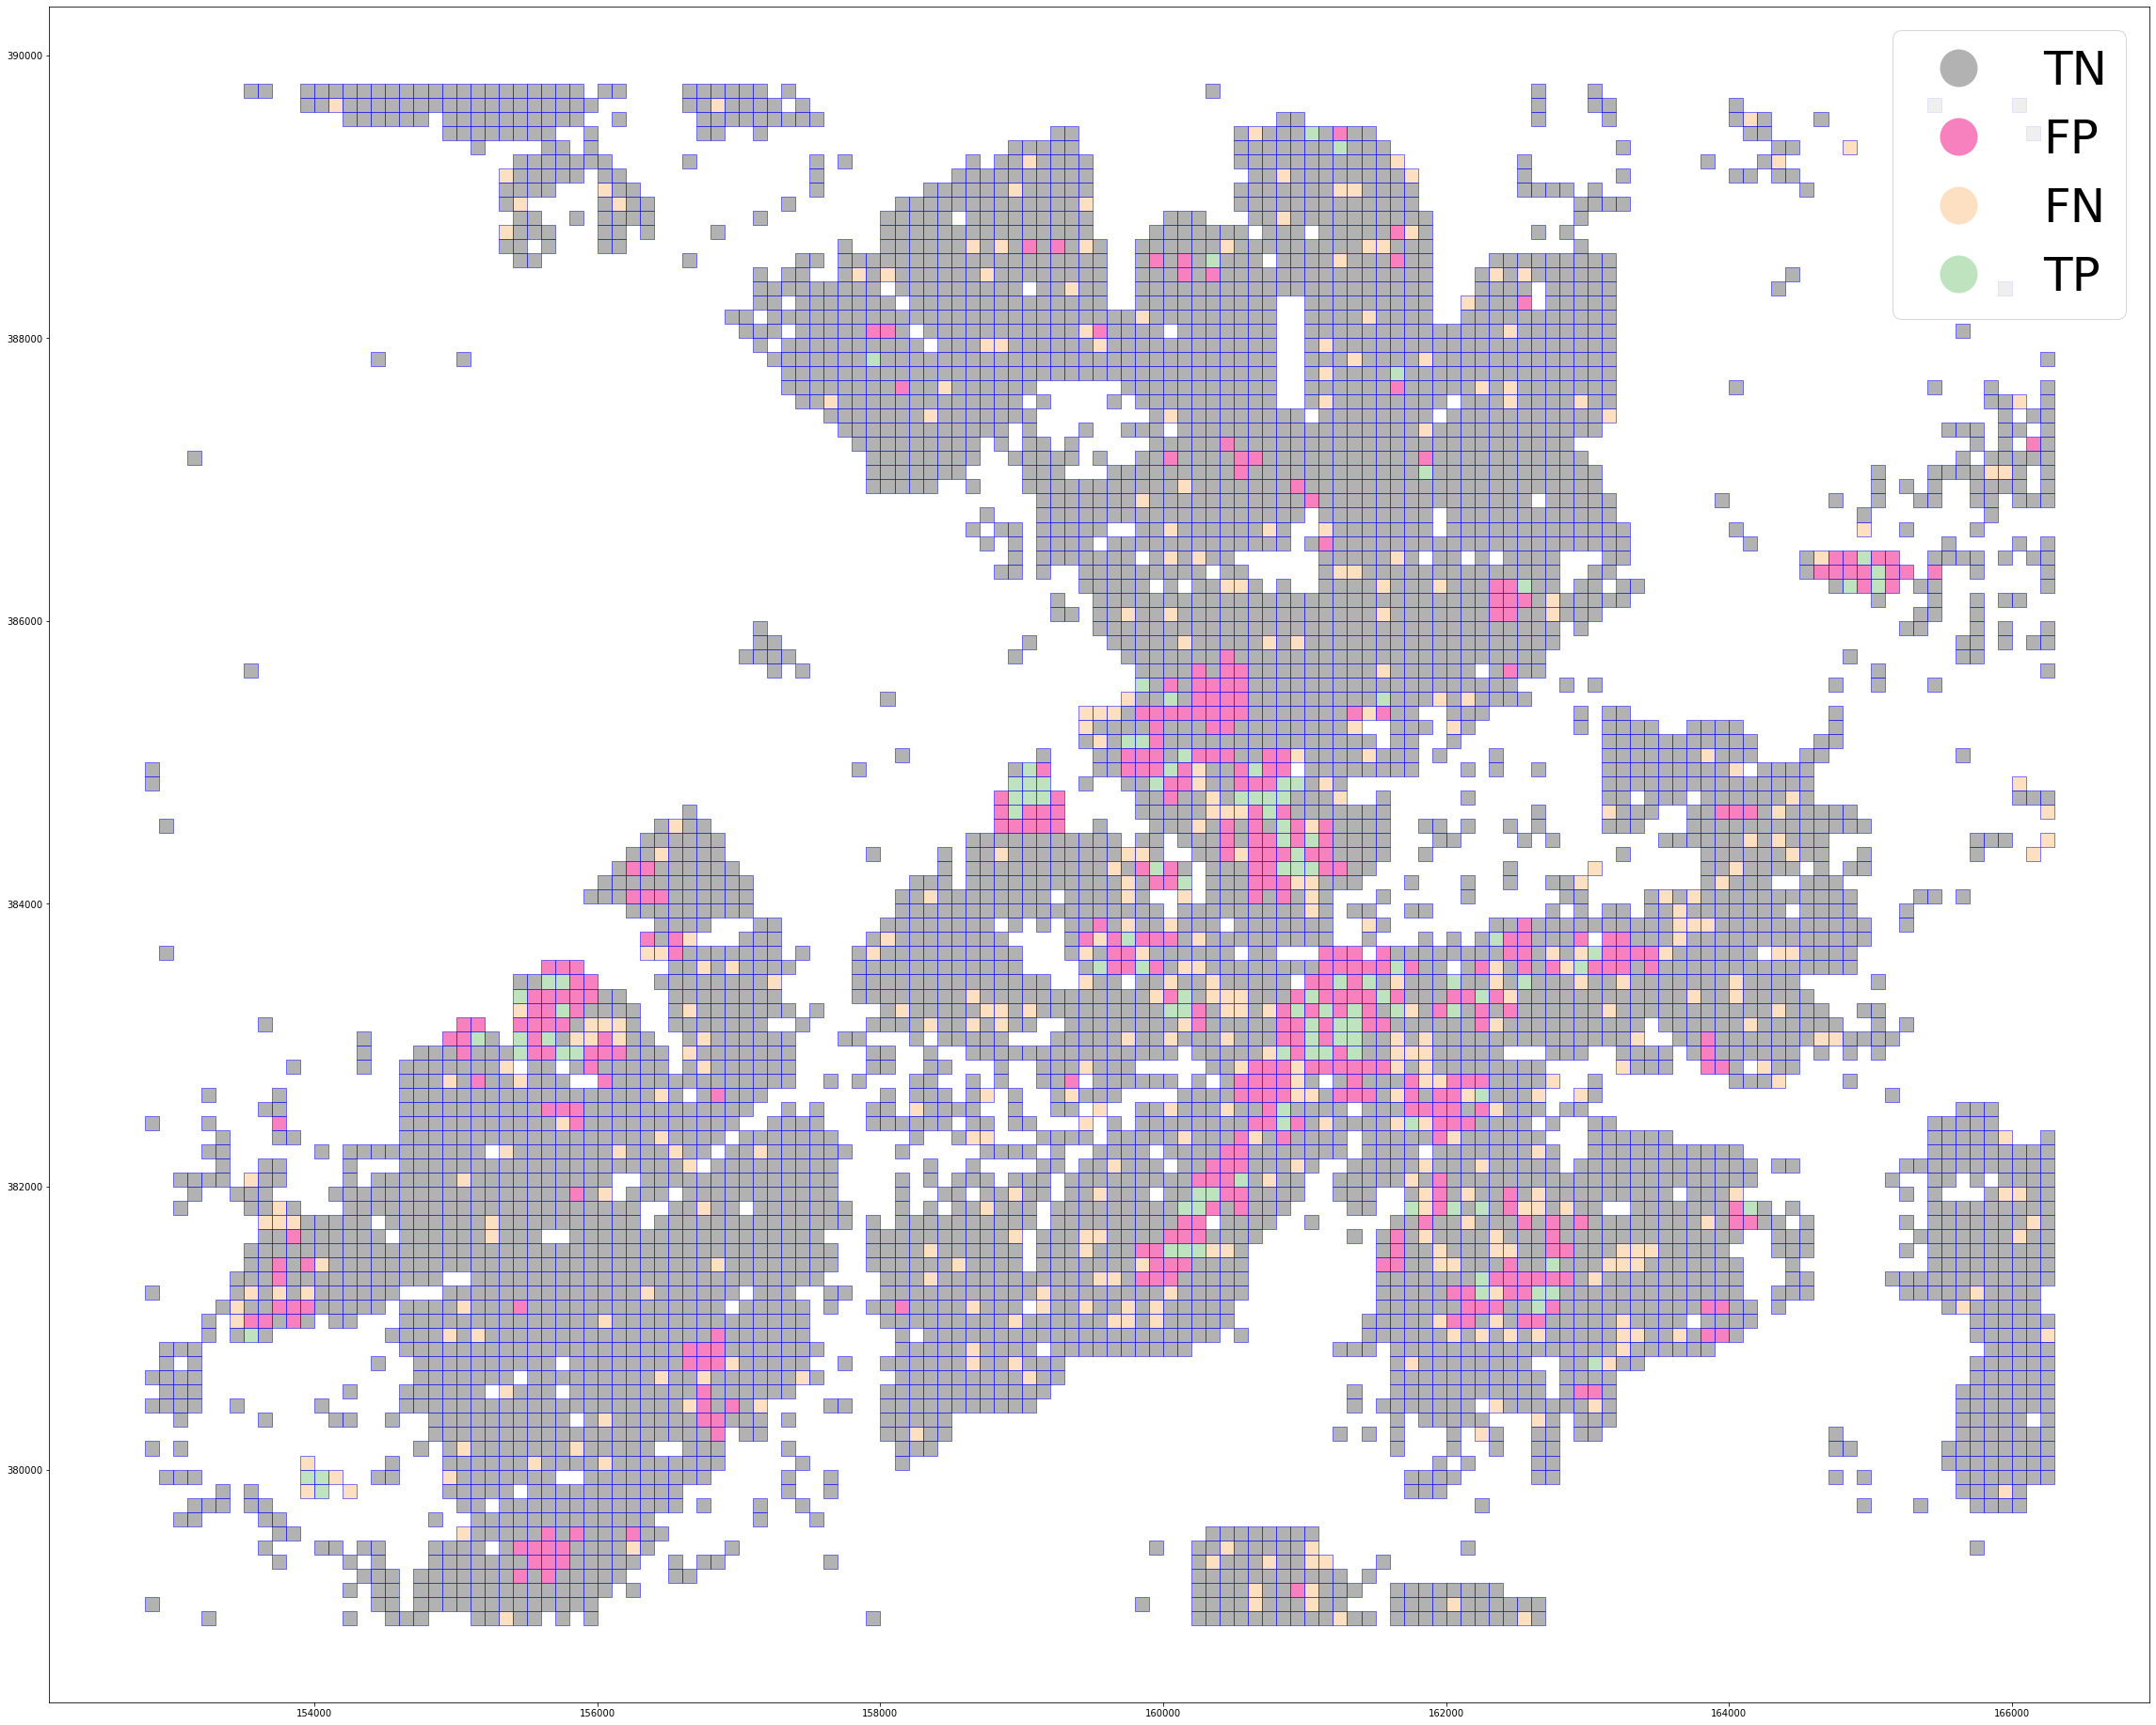

In [52]:
df19["preds"] = Yhat
df19["predicted"] = 0

def checker(d):
    if d["y"] == 0 and d["preds"] == 0:
        return 0
    if d["y"] == 0 and d["preds"] == 1:
        return 1
    if d["y"] == 1 and d["preds"] == 0:
        return 2
    if d["y"] == 1 and d["preds"] == 1:
        return 3
    
df19["checked"] = df19.apply(checker, axis =1)

fig = plt.figure(figsize=(40, 40))
ax = plt.gca()
mapper = {0: "TN", 1: "FP", 2 : "FN", 3: "TP"}
df19.plot(figsize = (40,40), cmap = "Accent_r", column = "checked", legend = True,
                                                           ax = ax, categorical=True, legend_kwds={'fontsize': 50, "markerscale":4},
                                                           alpha=0.5, edgecolor = "b")
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
                
legend = ax.get_legend()             
replace_legend_items(legend, mapper)
plt.show()

In [53]:
recall_score(Y_test, Yhat)

0.2144212523719165

In [54]:
precision_score(Y_test, Yhat)

0.2144212523719165

In [56]:
import sklearn.metrics as metrics
print(metrics.classification_report(Y_test, Yhat, digits=3))

              precision    recall  f1-score   support

         0.0      0.927     0.927     0.927      5647
         1.0      0.214     0.214     0.214       527

    accuracy                          0.866      6174
   macro avg      0.571     0.571     0.571      6174
weighted avg      0.866     0.866     0.866      6174

